In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [2]:
from jax import config
config.update('jax_enable_x64', True)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from functools import partial
from jax import vmap
from jax.scipy import stats
from jax.scipy.special import gamma, gammaln, logsumexp
from scipy.ndimage import gaussian_filter1d

In [4]:
%config InlineBackend.figure_format = 'retina'

# helper functions

In [5]:
def map_xy_to_p(xy):
    """
    p1, p2, p3 linearly interpolate between [0, 1] as we move from each vertex to the opposite edge
    this mapping ensures that p1+p2+p3=1 always (inside the traingle)
    """
    x, y = xy
    p1 = y
    p2 = x - 0.5*y
    p3 = 1 - x - 0.5*y
    return jnp.array([p1, p2, p3])

def map_p_to_xy(p):
    y = p[0]
    x = p[1] + 0.5*p[0]
    return jnp.array([x, y])

# test mappings
xy = jnp.array([0.3, 0.4])
assert jnp.allclose(map_p_to_xy(map_xy_to_p(xy)), xy)

def make_grid(s=500, eps=1e-6):

    # create a grid of (x, y) coordinates
    x = jnp.linspace(0, 1, s)
    y = jnp.linspace(0, 1, s)
    y, x = jnp.meshgrid(x, y)
    xy = jnp.stack([x, y], -1)

    # map each (x, y) to (p1, p2, p3) 
    p = vmap(vmap(map_xy_to_p))(xy)

    # discard negative values (outside of traingle) or tiny values (for numerical stability)
    valid = jnp.all(p > eps, axis=-1) # [s, s]
    p = p.at[~valid].set(0)
    
    return xy, p, valid

# density functions

In [6]:
def categ_logpdf(logp):
    return logp[0]

def dir_logpdf(logp, alpha, posterior=True, min_logprob=None):
    n_class = len(logp)
    alpha = (alpha*jnp.ones(n_class)).at[0].add(posterior)
    if min_logprob is not None: logp = logp.clip(min=min_logprob)
    lnB = jnp.sum(gammaln(alpha)) - gammaln(jnp.sum(alpha)) # normalization constant
    return -lnB + ((alpha-1)*logp).sum()

def ndg_post_logpdf(logp, alpha):
    n_class = len(logp)
    alpha = (alpha*jnp.ones(n_class)).at[0].add(1)
    var = jnp.log(1 / alpha + 1)
    mean = jnp.log(alpha) - var / 2
    mean -= mean.max() # correct for the use of logprobs instead of logits
    log_posterior = (-0.5 * (logp - mean)**2 / var).sum()
    return log_posterior

def ndg_prior_logpdf(logp, alpha):
    alpha = jnp.array([alpha, 1+alpha])
    var = jnp.log(1 / alpha + 1)
    mu = jnp.log(alpha) - var / 2
    mu -= mu[1] # set mu1 to 0
    return (-0.5 * (logp - mu[0])**2 / var[0]).sum()

def ndg_like_logpdf(logp, alpha):
    alpha = jnp.array([alpha, 1+alpha])
    var = jnp.log(1 / alpha + 1)
    mu = jnp.log(alpha) - var / 2
    mu -= mu[1] # set mu1 to 0
    a = (var[0]*mu[1]-var[1]*mu[0]) / (var[0]*var[1])
    b = (var[1]-var[0])/(2*var[0]*var[1])
    # print(f'{a=:.2f}, {b=:.2f}')
    return (a*logp[0] + b*logp[0]**2).sum()

def confidence_logpdf(logp, T, posterior=True):
    log_prob = (1/T-1) * logp.max() # prior
    if posterior: log_prob += logp[0]
    return log_prob

def reparametrize_logits(f):
    def out_fn(logits):
        logp = jax.nn.log_softmax(logits)
        return f(logp)
    return out_fn

In [7]:
# test dirichlet implementation
alpha = jnp.array(3*[0.1])
logp = jnp.log(jnp.array([0.2, 0.2, 0.6]))
my_prob = dir_logpdf(logp, alpha, posterior=False)
jax_prob = stats.dirichlet.logpdf(jnp.exp(logp), alpha)
assert my_prob == jax_prob

In [8]:
# test ndg factorization
alpha = 1e-6
key = jax.random.PRNGKey(0)
p = jax.random.dirichlet(key, 0.1*jnp.ones(10), [20])
logp = jnp.log(p)
prior = vmap(partial(ndg_prior_logpdf, alpha=alpha))(logp)
like = vmap(partial(ndg_like_logpdf, alpha=alpha))(logp)
post = vmap(partial(ndg_post_logpdf, alpha=alpha))(logp)
diff = post - (prior + like) # should be equal up to a constant
assert jnp.all(jnp.isclose(diff, diff[0]))

# distribution slices

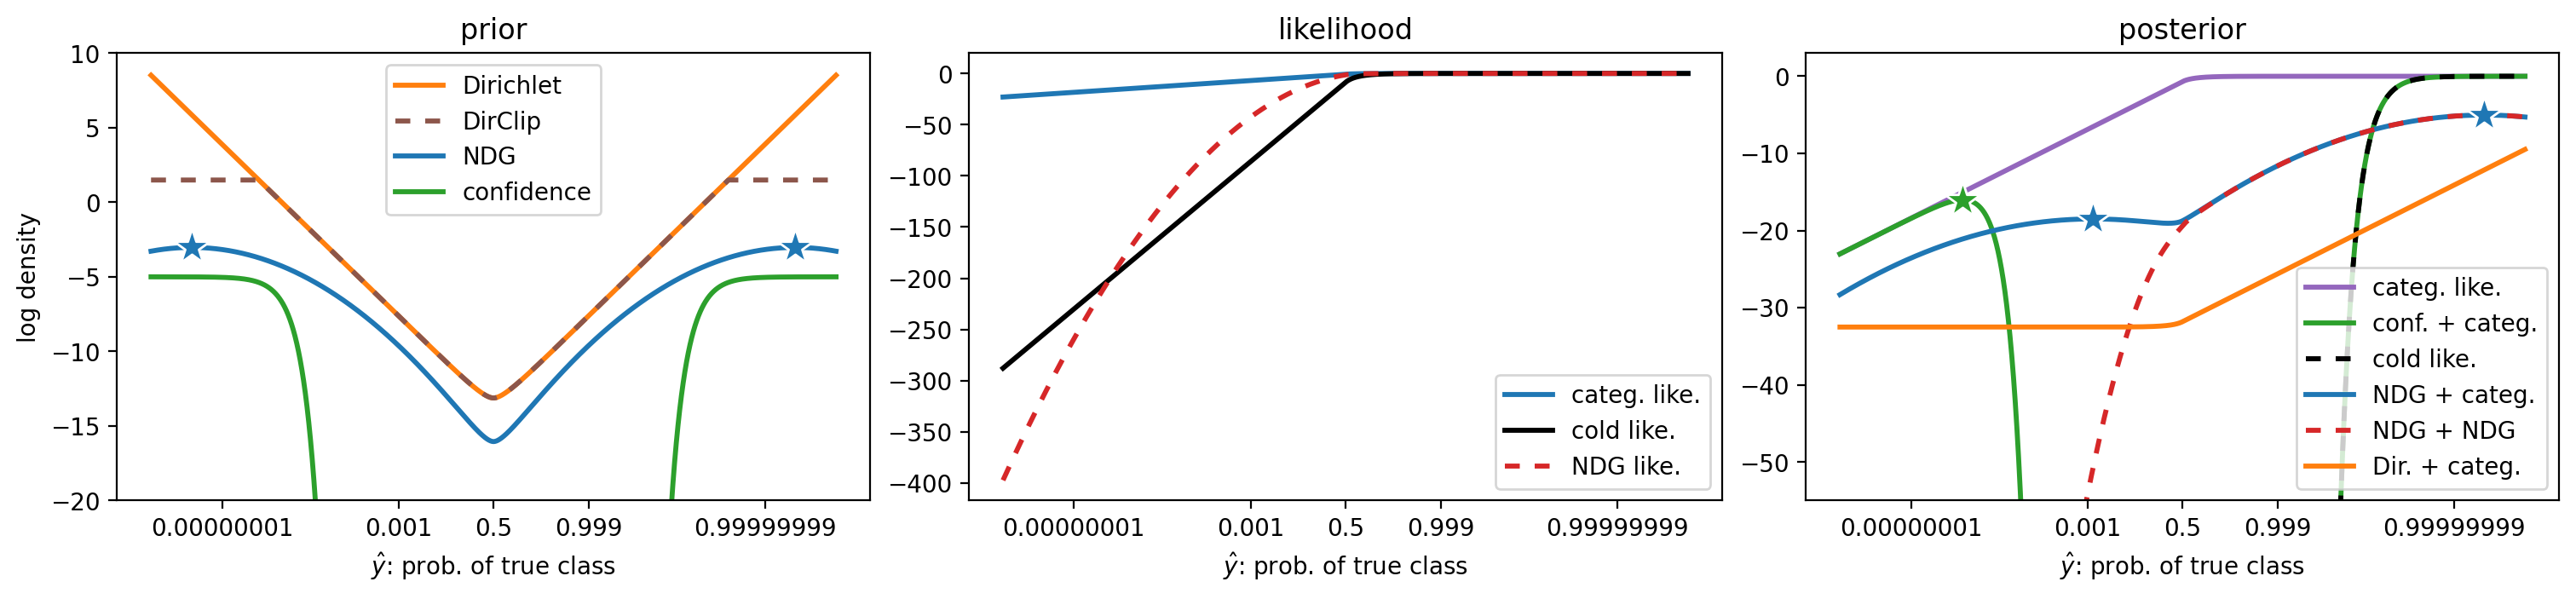

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3.4), layout='constrained')
lw = 2.1

# set x grid
# p0 is x and all other classes have the same prob.
n_class = 2
p0 = jnp.geomspace(1e-10, 0.5, 1_000)
p0 = jnp.concatenate([p0, 1-p0[::-1][1:]])
x = jnp.arange(len(p0))
p_other = (1 - p0) / (n_class-1)
p_vect = jnp.stack([p0, *(n_class-1)*[p_other]], -1)

# check that p is valid
assert jnp.allclose(p_vect.sum(-1), 1)
logp_vect = jnp.log(p_vect)

# evaluate distributions
alpha = 1e-6
T = 3e-7
dir_prior = vmap(partial(dir_logpdf, alpha=alpha, posterior=False))(logp_vect)
dirclip_prior = vmap(partial(dir_logpdf, alpha=alpha, posterior=False, min_logprob=-16))(logp_vect)
ndg_prior = vmap(partial(ndg_prior_logpdf, alpha=alpha))(logp_vect)
conf_prior = (1/T - 1) * logp_vect.max(-1)
ndg_like = vmap(partial(ndg_like_logpdf, alpha=alpha))(logp_vect)
categ_like = vmap(categ_logpdf)(logp_vect)

# prior
axs[0].set_title('prior')
axs[0].plot(x, dir_prior, label='Dirichlet', c='C1', lw=lw)
axs[0].plot(x, dirclip_prior, label='DirClip', c='C5', ls=(0, (3, 3)), lw=lw)
axs[0].plot(x, ndg_prior+12, label='NDG', c='C0', lw=lw)
axs[0].plot(x, conf_prior-5, label='confidence', c='C2', lw=lw)
axs[0].set_ylim((-20, 10))
axs[0].legend()

# highlight local maxima
y = ndg_prior+12; c = 'C0'
for max_idx in jnp.where((y[:-2] < y[1:-1]) & (y[1:-1] > y[2:]))[0]:
    axs[0].scatter([max_idx], [y[max_idx]], color=c, marker='*', s=250, zorder=5, clip_on=False, edgecolors='white')

# likelihood
axs[1].set_title('likelihood')
axs[1].plot(x, categ_like, label='categ. like.', c='C0', lw=lw)
axs[1].plot(x, categ_like/0.08, label='cold like.', c='black', lw=lw)
axs[1].plot(x, ndg_like, label='NDG like.', c='C3', ls=(0, (3, 3)), lw=lw)
# axs[1].set_ylim((-55, 3))
axs[1].legend()

# posterior
axs[2].set_title('posterior')
axs[2].plot(x, categ_like, label='categ. like.', c='C4', lw=lw)
axs[2].plot(x, conf_prior+categ_like, label='conf. + categ.', c='C2', lw=lw)
axs[2].plot(x, categ_like/T, label='cold like.', c='black', ls=(0, (3, 3)), lw=lw)
axs[2].plot(x, ndg_prior+categ_like+10, label='NDG + categ.', c='C0', lw=lw)
axs[2].plot(x, ndg_prior+ndg_like+10, label='NDG + NDG', c='C3', ls=(0, (3, 3)), lw=lw)
axs[2].plot(x, dir_prior+categ_like-18, label='Dir. + categ.', c='C1', lw=lw)
# axs[2].plot(x, dirclip_prior+categ_like-18, label='DirClip + categ.', c='C5', ls=(0, (3, 4)))
axs[2].set_ylim((-55, 3))
axs[2].legend(loc='lower right')

# highlight local maximum
for y, c in ((ndg_prior+categ_like+10, 'C0'), (conf_prior+categ_like, 'C2')):
    for max_idx in jnp.where((y[:-2] < y[1:-1]) & (y[1:-1] > y[2:]))[0]:
        axs[2].scatter([max_idx], [y[max_idx]], color=c, marker='*', s=250, zorder=5, clip_on=False, edgecolors='white')

# x ticks
for ax in axs:
    vals = (1e-8, 1e-3, 0.5, 1-1e-3, 1-1e-8)
    idxs = jnp.searchsorted(p0, jnp.array(vals))
    labels = [f'{x:.10f}'.rstrip('0').rstrip('.') for x in vals]
    ax.set_xticks(idxs, labels)
    ax.set_xlabel('$\\hat{y}$: prob. of true class')
    
axs[0].set_ylabel('log density')
# plt.savefig('../plots/distribution_slices.pdf')
plt.show()

# gradients

In [10]:
# set distributions to plot
to_plot = (
    (lambda logp: logp[0], 'a) categ. like.'),
    # (lambda logp: logp[0]/0.1, 'categ. like. (T=0.1)'),
    # (partial(ndg_post_logpdf, alpha=0.01), 'NDG(0.01)'),
    # (partial(confidence_logpdf, T=0.1), 'Conf(0.1)'),
    (partial(dir_logpdf, alpha=0.01, posterior=False), 'b) Dir(0.01) prior'),
    (partial(dir_logpdf, alpha=0.01, posterior=True), 'c) Dir(0.01) posterior'),
)

In [11]:
%%time
# compute gradient trajectories

# static plot parameters
lr = 0.05
n_steps = 1_000
n_particles = 50

# animation parameters
# lr = 0.05
# n_steps = 300
# n_particles = 500

# sample initial logits (predicted probabilities)
key = jax.random.PRNGKey(0)
logits = jax.random.normal(key, [n_particles, 3])

# get trajectories in logit space
def get_logit_trajectory(log_pdf_fn, logits_init):

    # take gradient steps
    grad_fn = jax.grad(reparametrize_logits(log_pdf_fn))
    def step_fn(logits, _):
        grad = vmap(grad_fn)(logits)
        logits += lr * grad
        return logits, logits
    _, trajectory = jax.lax.scan(step_fn, logits_init, xs=None, length=n_steps)
    
    return trajectory.transpose(1, 0, 2) # [n_particles, n_steps, 2]
trajectories_logits = jnp.stack([get_logit_trajectory(pdf, logits) for pdf, _ in to_plot]) # [n_distributions, n_particles, n_steps, 2]

# map logits to xy
trajectories_probs = jax.nn.softmax(trajectories_logits)
trajectories_xy = vmap(vmap(vmap(map_p_to_xy)))(trajectories_probs)

CPU times: user 327 ms, sys: 16.3 ms, total: 343 ms
Wall time: 336 ms


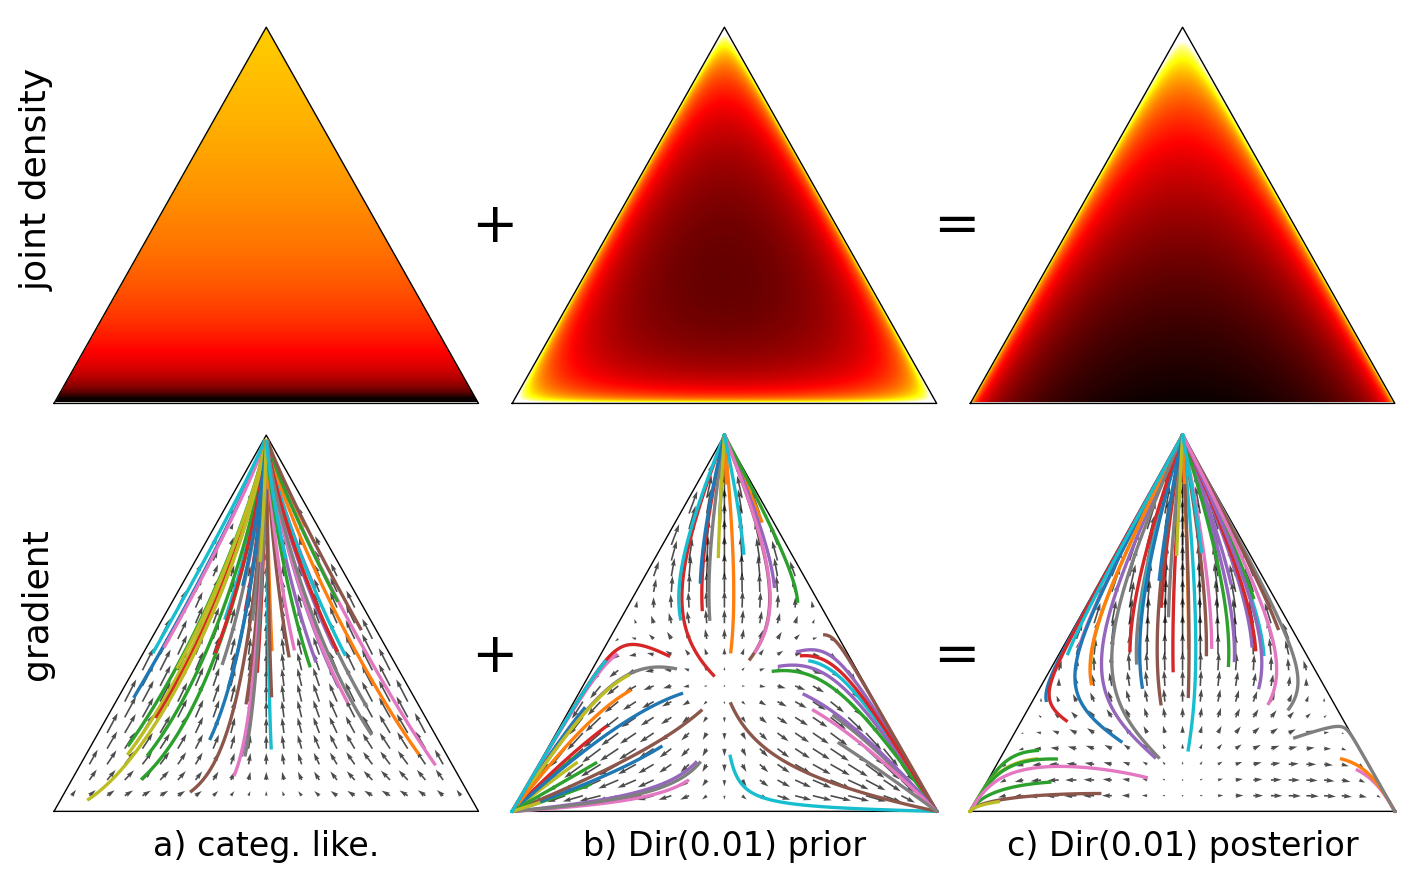

CPU times: user 1.69 s, sys: 68.5 ms, total: 1.76 s
Wall time: 1.38 s


In [12]:
%%time
# plot gradient trajectories (static plot)
fig, axs = plt.subplots(2, len(to_plot), figsize=(7, 4.3), layout='constrained')
cm = mpl.cm.ScalarMappable(cmap='tab10')

for i, (log_pdf_fn, name) in enumerate(to_plot):
    axs[1, i].set_xlabel(name, fontsize=12)
    
    # plot pdf
    xy, p, valid = make_grid()
    pdf_valid = vmap(log_pdf_fn)(jnp.log(p[valid]))
    pdf_valid -= logsumexp(pdf_valid)
    img = jnp.zeros(valid.shape).at[valid].set(pdf_valid)
    axs[0, i].imshow(img.T, origin='lower', extent=[0, 1, 0, 1], vmin=-15, vmax=-8.5, cmap='hot', aspect='auto')
    # axs[0, i].contourf(img.T, origin='lower', extent=[0, 1, 0, 1], vmin=-19, vmax=-6, cmap='hot', levels=20)
    
    # create grid of points where we compute gradients
    x = jnp.linspace(0, 1, 25)
    y = jnp.linspace(0, 1, 25)
    xy = jnp.stack(jnp.meshgrid(x, y), -1).reshape((-1, 2))
    p0 = vmap(map_xy_to_p)(xy)
    valid = jnp.all(p0 > 1e-6, axis=-1)
    p0 = p0[valid]
    
    # compute gradient in logits space, then map to xy space
    logits0 = jnp.log(p0)
    grad_fn = jax.grad(reparametrize_logits(log_pdf_fn))
    grads = vmap(grad_fn)(logits0)
    logits1 = logits0 + 0.01 * grads
    p1 = jax.nn.softmax(logits1)
    xy0 = vmap(map_p_to_xy)(p0)
    xy1 = vmap(map_p_to_xy)(p1)
    dxy = xy1 - xy0
    axs[1, i].quiver(*xy0.T, *dxy.T, alpha=0.7)
    axs[1, i].set_aspect('auto')
    
# plot triangle frames
for ax in axs.flatten():
    ax.plot((0, 0.5, 1, 0), (0, 1, 0, 0), c='black', lw=0.5)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

# row labels
axs[0, 0].text(0.0, 0.3, 'joint density', size=13, rotation=90, ha='right', va='bottom')
axs[1, 0].text(0.0, 0.35, 'gradient', size=13, rotation=90, ha='right', va='bottom')
    
# add '+' and '=' text beween axes to show that prior + likelihood = posterior
for ax in axs[1:, 0]: ax.set_yticks([], None)
for h in (0.25, 0.75):
    fig.text(0.345, h, "+", ha='center', va='center', fontsize=20)
    fig.text(0.675, h, "=", ha='center', va='center', fontsize=20)
    
# plot trajectories (no animation)
for ax, trajectory in zip(axs[1, :], trajectories_xy):
    lines = LineCollection(trajectory, lw=1.2, colors=plt.cm.tab10.colors)
    ax.add_collection(lines)

# set ax limits
for ax in axs.flatten():
    m = 0.02 # margin
    ax.set_xlim((-m, 1+m))
    ax.set_ylim((-m, 1+m))

# plt.savefig('../plots/dirichlet_gradients.pdf')
plt.show()

In [13]:
# %%time
# # plot trajectories (animated)
# # warning: this cell takes ~2 mins to run despite my best effort to optimize
# # the code - if you know how to speed it up, please open an issue!
# fig.set_dpi(140)
# fps = 12
# anim_time = 10
# n_frames = int(anim_time * fps)
# key = jax.random.PRNGKey(0)
# start_idx = jax.random.uniform(key, [n_particles], maxval=n_steps-1).astype(jnp.int32)
# mpl.rcParams['animation.embed_limit'] = 100_000_000 # set increased (100 MB) animation limit

# # remove previous lines
# for ax in axs[1, :]:
#     for collection in ax.collections:
#         if isinstance(collection, LineCollection):
#             collection.remove()

# # use a separate line for each line trajectory step
# xy0 = trajectories_xy[:, :, :-1, :] # [n_distributions, n_particles, n_steps-1, xy]
# xy1 = trajectories_xy[:, :, 1:,  :] # [n_distributions, n_particles, n_steps-1, xy]
# fig_segments = jnp.stack([xy0, xy1], -2) # [n_distributions, n_particles, n_steps-1, 2, xy]
# fig_segments.shape

# # draw new lines
# cm = plt.cm.tab10
# fig_lines = []
# for ax, ax_segments in zip(axs[1, :], fig_segments):
#     # ax_segments.shape = [n_particles, n_steps-1, 2, xy]
#     colors = np.array(cm.colors)[np.arange(n_particles)%cm.N] # [n_particles]
#     colors = colors[:, None].repeat(n_steps-1, 1) # [n_particles, n_steps-1]
#     ax_lines = LineCollection(np.concatenate(ax_segments), lw=1.5, colors=np.concatenate(colors))
#     ax.add_collection(ax_lines)
#     fig_lines += [ax_lines]

# def update(frame_idx):
#     """the same lines are plotted across all frames; only their alpha value is changing between frames"""
    
#     # each particle has a different 'starting index'
#     # head has index 0, tail goes to -infty, anything >0 is not plotted
#     step_idx = jnp.arange(n_steps-1) - frame_idx * (n_steps / n_frames) # [n_steps-1]
#     step_idx = step_idx[None].repeat(n_particles, 0) # [n_particles, n_steps-1]
#     step_idx += start_idx[:, None] # [n_particles, n_steps-1]
    
#     # transparency value for each line segment, goes from 0 to 1
#     decay = 0.1
#     alphas = jnp.where(step_idx<=0, jnp.exp(decay*step_idx), 0)
    
#     # to make the animationation loop smoothy, each particle is also plotted shifted by -1 period
#     step_idx -= n_steps
#     alphas += jnp.where(step_idx<=0, jnp.exp(decay*step_idx), 0)
#     alphas = alphas.clip(0, 1)
    
#     # update line collection alphas
#     for ax, ax_lines in zip(axs[1, :], fig_lines):
#         ax_lines.set_alpha(jnp.concatenate(alphas, 0))
    
#     return fig_lines

# anim = FuncAnimation(fig, update, n_frames, interval=1_000/fps, blit=True)
# writer = mpl.animation.PillowWriter(fps=fps)
# anim.save('../plots/gradients.gif', writer=writer)

In [14]:
# under gradient descent, how many particles would converge to the wrong class?
alpha = 0.01
n_class = 3
thr = 0.5 # how samples have prob. of true clas <thr?
key = jax.random.PRNGKey(0)
p = jax.random.dirichlet(key, jnp.ones([n_class]), [10_000])
logits = jnp.log(p)
log_pdf_fn = partial(dir_logpdf, alpha=alpha, posterior=True)
traj_logits = get_logit_trajectory(log_pdf_fn, logits)
traj_probs = jax.nn.softmax(traj_logits) # [n_trajectories, n_steps, n_class]
p0 = traj_probs[:, -1, 0] # last position of class 0
print(f'{(p0 < thr).mean():.2%}')

# now compare that with directly sampling the posterior
# prior joint is Dir(a, a, a)
# posterior joint is Dir(1+a, a, a)
# posterior marginal is B(1+a, 2*a)
# https://en.wikipedia.org/wiki/Dirichlet_distribution#Marginal_distributions
print(f'{stats.beta.cdf(thr, 1+alpha, (n_class-1)*alpha):.2%}')

30.81%
1.36%


# training stability

In [15]:
def get_dlogy(p_j, alpha_scalar, n_class=10, analytical=False, eps=1e-6):
    """
    computes the change in prob. of true class for dirichlet posterior
    p_j: predicted prob. of a wrong class (j≠y)
    we assume that all classes other than j have the same prob.
    """
    # set initial vector of probabilities
    # for convenience, we assume that the index of the true class is zero
    q = (1-p_j)/(n_class-1) # prob. of all classes other than p_j
    p = (q*jnp.ones([n_class])).at[-1].set(p_j) # [q, q... q, p_j]
    
    # analytically compute change in prob. of true class, using derived expression from paper
    if analytical:
        alpha = (alpha_scalar*jnp.ones(n_class)).at[0].add(1) # conjugate posterior
        g = alpha - 1
        dlogy = g[0] - g.sum()*p[0] - jnp.dot(p, g) + g.sum()*(p**2).sum()

    # otherwise, use finite difference
    # this option is useful to check the validity of the closed-form expression above
    if not analytical:
        logp0 = jnp.log(p)
        logits0 = logp0
        log_pdf_fn = partial(dir_logpdf, alpha=alpha_scalar, posterior=True)
        grad = jax.grad(reparametrize_logits(log_pdf_fn))(logits0)
        logits1 = logits0 + eps * grad
        logp1 = jax.nn.log_softmax(logits1)
        dlogy = (logp1[0] - logp0[0]) / eps
    
    return dlogy

In [16]:
# check validity of analytical expression
# note: the absolute tolerance here is actually a very small number compared to the scale of values
key = jax.random.PRNGKey(0)
alphas, pjs = jax.random.uniform(key, [2, 100])
analytical = vmap(partial(get_dlogy, analytical=True))(pjs, alphas)
finitediff = vmap(partial(get_dlogy, analytical=False))(pjs, alphas)
print(jnp.abs(analytical).mean(), jnp.abs(finitediff).mean())
assert jnp.allclose(analytical, finitediff, atol=1e-6)

1.281263027743845 1.2812634919923127


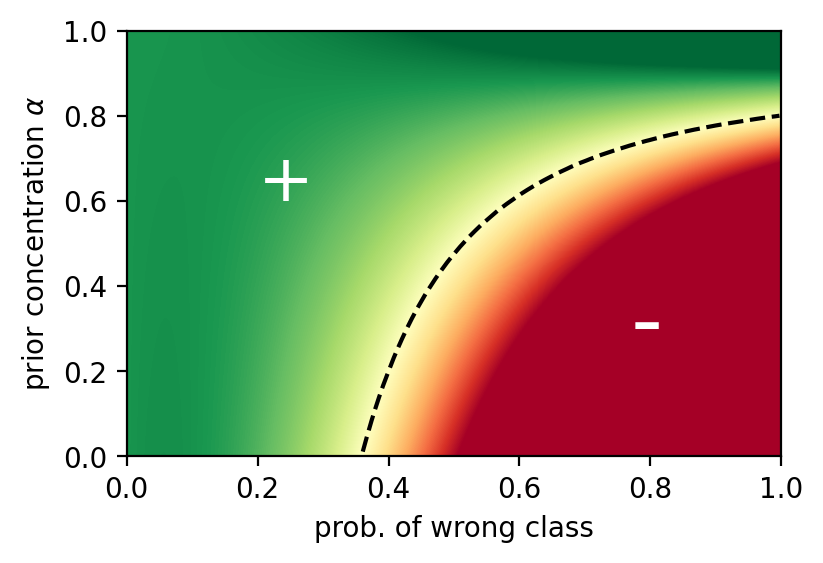

CPU times: user 868 ms, sys: 58.7 ms, total: 927 ms
Wall time: 686 ms


In [17]:
%%time
# phase diagram
fig, ax = plt.subplots(figsize=(4, 2.7), layout='constrained')

# compute grid
alphas = jnp.linspace(0, 1, 600)
pjs = jnp.linspace(0, 1, 800)
m = vmap(vmap(get_dlogy, in_axes=(None, 0)), in_axes=(0, None))(pjs, alphas)

# plot image
ax.imshow(m.T, cmap='RdYlGn', aspect='auto', origin='lower', extent=(pjs[0], pjs[-1], alphas[0], alphas[-1]), vmin=-1.1, vmax=1.1)
ax.text(0.2, 0.6, '+', c='white', fontsize=24)
ax.text(0.77, 0.25, '-', c='white', fontsize=32)
ax.set_xlabel('prob. of wrong class')
ax.set_ylabel(r'prior concentration $\alpha$')

# draw the threshold line
x = pjs
y = alphas[jnp.argmax(m > 0, axis=1)]
x, y = x[y>0], y[y>0]
x, y = gaussian_filter1d(x, 2), gaussian_filter1d(y, 2) # plot a nice smooth line
ax.plot(x, y, ls='--', color='black')

# plt.savefig('../plots/dirichlet_convergence.pdf')
plt.show()

In [18]:
# find exact threshold for divergence for a given point
f = lambda alpha: get_dlogy(1-1e-7, alpha)
scipy.optimize.bisect(f, 0, 1)

0.7999999797903001

In [19]:
%%time
# compute critical alpha using finite differences
def check_step_direction(alpha: float, n_class: int):

    # set distribution
    # the correct label is '0'
    alpha_prior = alpha * jnp.ones(n_class)
    alpha_post = alpha_prior.at[0].add(1)
    logpdf_fn = lambda logits: ((alpha_post-1) * jax.nn.log_softmax(logits)).sum()

    # set initial logits.
    # they have very high confidence in label 1 (different from the true label)
    logits0 = (-10 * jnp.ones(n_class)).at[1].set(0)
    logprobs0 = jax.nn.log_softmax(logits0)

    # compute logits after gradient step
    grad = jax.grad(logpdf_fn)(logits0)
    logits1 = logits0 + 0.001 * grad
    logprobs1 = jax.nn.log_softmax(logits1)

    # did we step in the direction of the true class?
    label_prob_increased = logprobs1[0] > logprobs0[0]
    return label_prob_increased

alphas = jnp.linspace(0, 1, 1000)
max_class = 100
m = jnp.ones((max_class-1, len(alphas)))
for i, n_class in enumerate(range(2, max_class+1)):
    # x = vmap(partial(check_step_direction, n_class=n_class))(alphas)
    x = jax.lax.map(partial(check_step_direction, n_class=n_class), alphas)
    m = m.at[i].set(x)

CPU times: user 4.63 s, sys: 157 ms, total: 4.79 s
Wall time: 4.62 s


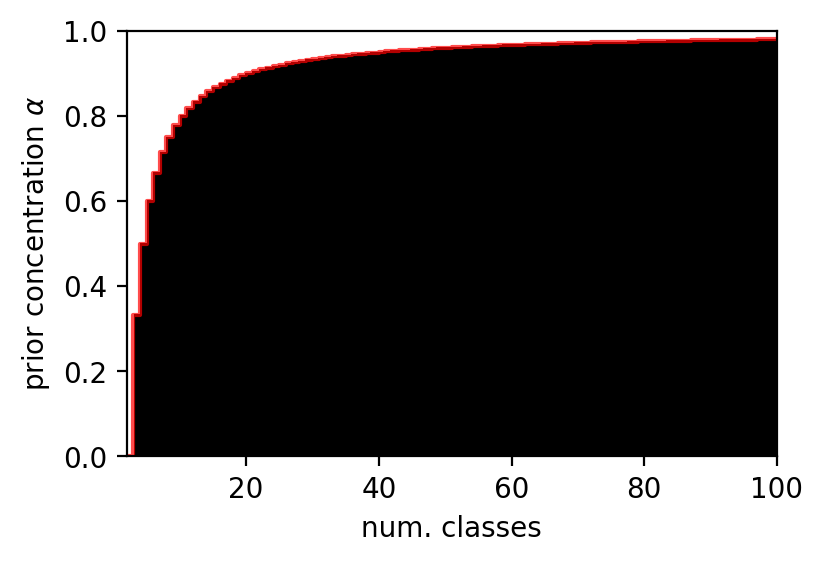

In [20]:
# plot critical alpha
fig, ax = plt.subplots(figsize=(4, 2.7), layout='constrained')

# numerical solution
ax.imshow(m.T, origin='lower', cmap='gray', aspect='auto', interpolation='nearest', extent=(2, max_class, 0, 1))

# analytical solution from paper
n_class = jnp.arange(2, 101)
thr = (n_class - 2) / n_class
plt.step(n_class, thr, where='post', alpha=0.7, color='red')

ax.set_xlabel('num. classes')
ax.set_ylabel(r'prior concentration $\alpha$')
# plt.savefig('../plots/dirichlet_critical_alpha.pdf')
plt.show()

# dirichlet density test

In [21]:
# shows that dirichlet pdf is maximized by small probabilities, rather than high confidence
alpha = 0.01
logits0 = jnp.array(2*[0]+[-15])
logits1 = jnp.array([0]+2*[-5.28827])
for logits in (logits0, logits1):
    print(', '.join(f'{p:.7}' for p in jax.nn.softmax(logits)))
    print(f'{jnp.exp(dir_logpdf(jax.nn.log_softmax(logits), alpha)):.2f}')

0.4999999, 0.4999999, 1.529511e-07
1102.84
0.99, 0.004999985, 0.004999985
3.60
